In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# =========================================================
# --- Models ---
# =========================================================
def S21_complex(f, f0, k, amp, phi):
    """Asymmetric complex S21 model (no delay)"""
    val = amp * np.exp(1j*phi) / (1 + 1j*2*(f - f0)/k)
    return np.concatenate([val.real, val.imag])

def S21_complex_delay(f, f0, k, amp, phi, tau):
    """Asymmetric complex S21 model with cable delay"""
    delay_phase = np.exp(-1j * 2 * np.pi * f * tau)
    val = amp * np.exp(1j*phi) / (1 + 1j*2*(f - f0)/k)
    val = val * delay_phase
    return np.concatenate([val.real, val.imag])

# =========================================================
# --- Initial guess ---
# =========================================================
def initial_guess(f, s21):
    mag = np.abs(s21)
    amp = np.max(mag)
    f0 = f[np.argmax(mag)]
    half_max = amp / 2
    indices = np.where(mag >= half_max)[0]
    k = f[indices[-1]] - f[indices[0]] if len(indices) >= 2 else (f[-1]-f[0])/10
    phi = 0.0
    return [f0, k, amp, phi]

def initial_guess_delay(f, s21):
    p0 = initial_guess(f, s21)
    tau = 1e-9   # 1 ns starting guess
    return p0 + [tau]

# =========================================================
# --- Polar fit functions ---
# =========================================================
def fit_and_plot_polar(file_path, f_start, f_end):
    """No delay model (for narrowband data)"""
    # Read CSV
    df = pd.read_csv(file_path)
    mag = df['Magnitude_abs'].values
    phase_deg = df['Phase_deg'].values
    phase_rad = np.deg2rad(phase_deg)

    # Frequency array
    f = np.linspace(f_start, f_end, len(mag))

    # Complex data
    s21 = mag * np.exp(1j*phase_rad)

    # Initial guess
    p0 = initial_guess(f, s21)

    # Fit
    ydata = np.concatenate([s21.real, s21.imag])
    popt, pcov = curve_fit(S21_complex, f, ydata, p0=p0)

    # Dense fit
    f_dense = np.linspace(f[0], f[-1], 2000)
    s21_fit_dense = popt[2]*np.exp(1j*popt[3]) / (1 + 1j*2*(f_dense - popt[0])/popt[1])

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(s21.real, s21.imag, 'o', markersize=4, label="Raw Data")
    plt.plot(s21_fit_dense.real, s21_fit_dense.imag, '-', color='black', label="Asymmetric Fit")
    plt.xlabel("Re(S21)")
    plt.ylabel("Im(S21)")
    plt.title(file_path.split("\\")[-1])
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Fit params for {file_path.split('\\')[-1]}:")
    print(f"  f0  = {popt[0]:.3e}")
    print(f"  k   = {popt[1]:.3e}")
    print(f"  amp = {popt[2]:.3e}")
    print(f"  phi = {popt[3]:.3f}")
    return popt

def fit_and_plot_polar_delay(file_path, f_start, f_end):
    """Delay model (for wideband data like 4–8 GHz)"""
    # Read CSV
    df = pd.read_csv(file_path)
    mag = df['Magnitude_abs'].values
    phase_deg = df['Phase_deg'].values
    phase_rad = np.deg2rad(phase_deg)

    # Frequency array
    f = np.linspace(f_start, f_end, len(mag))

    # Complex data
    s21 = mag * np.exp(1j*phase_rad)

    # Initial guess
    p0 = initial_guess_delay(f, s21)

    # Fit
    ydata = np.concatenate([s21.real, s21.imag])
    popt, pcov = curve_fit(S21_complex_delay, f, ydata, p0=p0)

    # Dense fit
    f_dense = np.linspace(f[0], f[-1], 20000)
    delay_phase = np.exp(-1j * 2 * np.pi * f_dense * popt[4])
    s21_fit_dense = (popt[2]*np.exp(1j*popt[3]) /
                     (1 + 1j*2*(f_dense - popt[0])/popt[1])) * delay_phase

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(s21.real, s21.imag, 'o', markersize=4, label="Raw Data")
    plt.plot(s21_fit_dense.real, s21_fit_dense.imag, '-', color='black', label="Asymmetric Fit + Delay")
    plt.xlabel("Re(S21)")
    plt.ylabel("Im(S21)")
    plt.title(file_path.split("\\")[-1])
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Fit params for {file_path.split('\\')[-1]}:")
    print(f"  f0  = {popt[0]:.3e}")
    print(f"  k   = {popt[1]:.3e}")
    print(f"  amp = {popt[2]:.3e}")
    print(f"  phi = {popt[3]:.3f}")
    print(f"  tau = {popt[4]:.3e} s")
    return popt

# =========================================================
# --- Files and ranges ---
# =========================================================
csv_files_with_range = [
    # 4–8 GHz → use delay model
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow0_BD_1Kz_4-8.csv", 4e9, 8e9, "delay"),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-40_BD_1Kz_4-8.csv", 4e9, 8e9, "delay"),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-55_BD_1Kz_4-8.csv", 4e9, 8e9, "delay"),

    # 5.5–6.5 GHz → use simple model
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow0_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, "simple"),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-40_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, "simple"),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-55_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, "simple"),
]

# =========================================================
# --- Run for all files ---
# =========================================================
for file_path, f_start, f_end, model in csv_files_with_range:
    if model == "delay":
        fit_and_plot_polar_delay(file_path, f_start, f_end)
    else:
        fit_and_plot_polar(file_path, f_start, f_end)

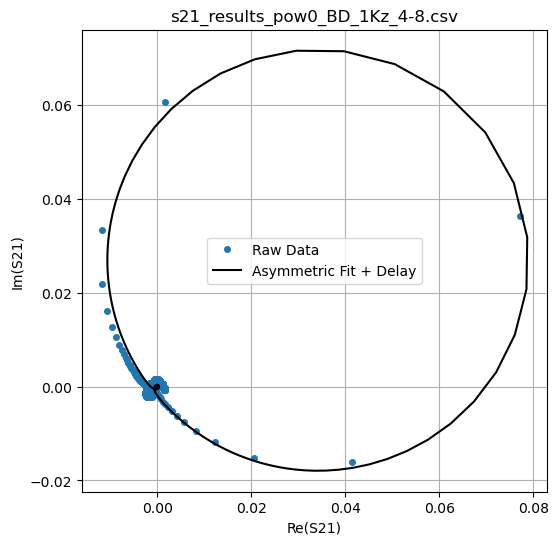

Fit params for s21_results_pow0_BD_1Kz_4-8.csv:
  f0  = 6.133e+09
  k   = 2.868e+06
  amp = 8.829e-02
  phi = 29.160
  tau = 1.718e-09 s


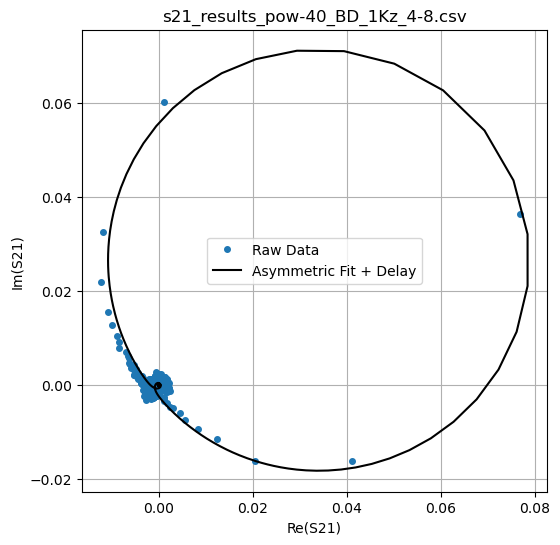

Fit params for s21_results_pow-40_BD_1Kz_4-8.csv:
  f0  = 6.133e+09
  k   = 2.893e+06
  amp = 8.794e-02
  phi = 43.099
  tau = 2.080e-09 s


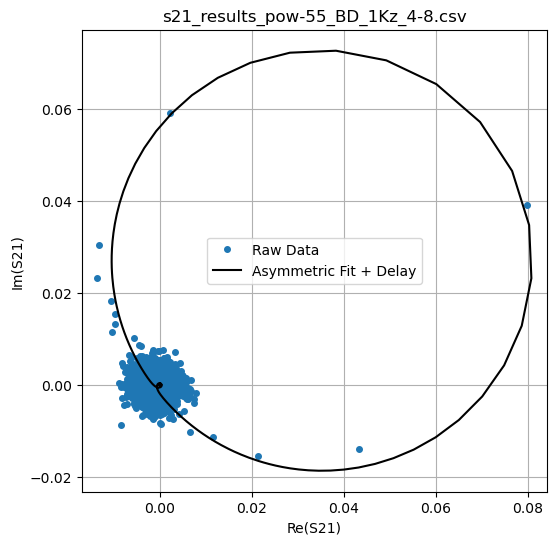

Fit params for s21_results_pow-55_BD_1Kz_4-8.csv:
  f0  = 6.133e+09
  k   = 2.860e+06
  amp = 9.008e-02
  phi = 27.562
  tau = 1.677e-09 s


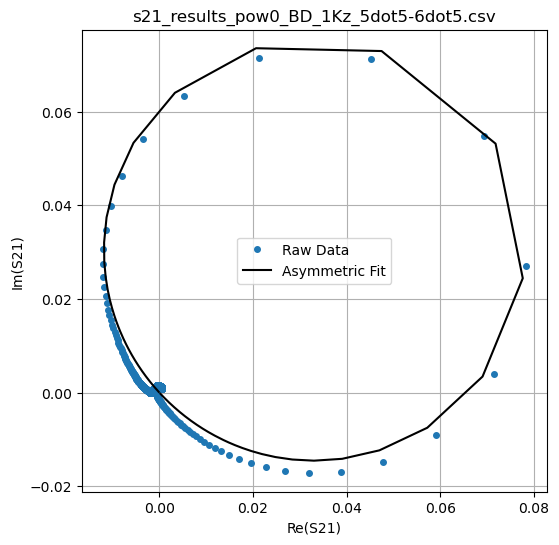

Fit params for s21_results_pow0_BD_1Kz_5dot5-6dot5.csv:
  f0  = 6.133e+09
  k   = 2.760e+06
  amp = 8.988e-02
  phi = 0.743


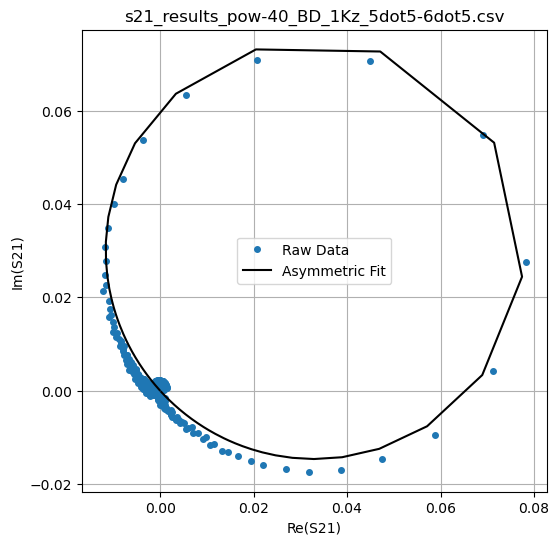

Fit params for s21_results_pow-40_BD_1Kz_5dot5-6dot5.csv:
  f0  = 6.133e+09
  k   = 2.759e+06
  amp = 8.949e-02
  phi = 0.739


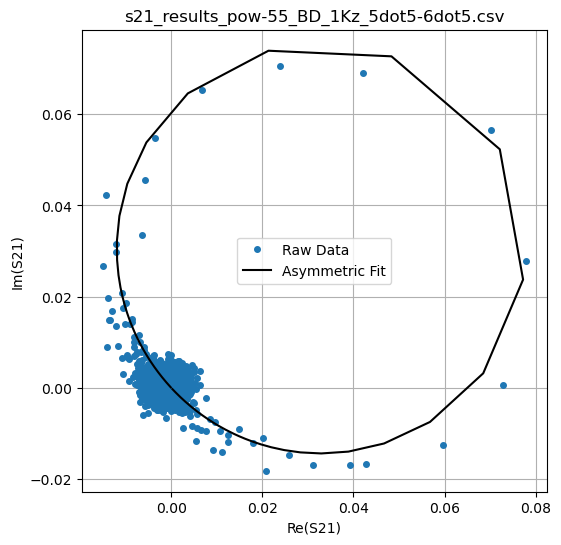

Fit params for s21_results_pow-55_BD_1Kz_5dot5-6dot5.csv:
  f0  = 6.133e+09
  k   = 2.767e+06
  amp = 8.976e-02
  phi = 0.748


In [2]:
# --- Calculate frequency for each fitted circle point based on nearest raw data ---
# Make sure 's21' (raw complex data) and 'f' (raw frequency array) are defined above

# For each fitted point, find nearest raw point in complex plane
f_fitted = []
for point in s21_fit_dense:
    # compute Euclidean distance to all raw data points
    distances = np.abs(s21 - point)
    nearest_idx = np.argmin(distances)
    f_fitted.append(f[nearest_idx])

f_fitted = np.array(f_fitted)

# Plot frequency mapping vs. index (to see density variation)
plt.figure(figsize=(7,4))
plt.plot(np.arange(len(f_fitted)), f_fitted/1e9, '-', color='purple')
plt.xlabel("Fitted circle point index")
plt.ylabel("Corresponding frequency (GHz)")
plt.title("Frequency corresponding to each fitted circle point")
plt.grid(True)
plt.show()

# Optional: print a few sample values
for i in range(0, len(f_fitted), len(f_fitted)//5):
    print(f"Point {i:4d} → freq = {f_fitted[i]/1e9:.6f} GHz")


NameError: name 's21_fit_dense' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# try to import fast nearest-neighbor (optional, faster)
try:
    from scipy.spatial import cKDTree as KDTree
    _HAS_KDTREE = True
except Exception:
    _HAS_KDTREE = False

# ---------------- Models (same as yours) ----------------
def S21_complex(f, f0, k, amp, phi):
    val = amp * np.exp(1j*phi) / (1 + 1j*2*(f - f0)/k)
    return np.concatenate([val.real, val.imag])

def S21_complex_delay(f, f0, k, amp, phi, tau):
    delay_phase = np.exp(-1j * 2 * np.pi * f * tau)
    val = amp * np.exp(1j*phi) / (1 + 1j*2*(f - f0)/k)
    val = val * delay_phase
    return np.concatenate([val.real, val.imag])

# ---------------- Initial guesses ----------------
def initial_guess(f, s21):
    mag = np.abs(s21)
    amp = np.max(mag)
    f0 = f[np.argmax(mag)]
    half_max = amp / 2
    indices = np.where(mag >= half_max)[0]
    k = f[indices[-1]] - f[indices[0]] if len(indices) >= 2 else (f[-1] - f[0]) / 10.0
    phi = 0.0
    return [f0, k, amp, phi]

def initial_guess_delay(f, s21):
    return initial_guess(f, s21) + [1e-9]

# ---------------- Core function: fit + map every fitted point ----------------
def fit_map_fitted_points(file_path, f_start, f_end, use_delay=False,
                          mag_in_db=False, unwrap_phase=True, n_dense=20000,
                          show_plots=True):
    """
    - Reads CSV with columns 'Magnitude_abs' and 'Phase_deg' (or edit if columns differ)
    - Fits S21 (delay model if use_delay=True)
    - Generates dense fitted circle points (s21_fit_dense) and f_dense
    - For each fitted point finds the nearest raw data point and assigns its frequency
    - Plots polar comparison and a mapping-plot (index -> freq)
    - Returns: popt, f_dense, s21_fit_dense, f_mapped (array same length as f_dense)
    """
    # --- read data
    df = pd.read_csv(file_path)
    mag_col = df['Magnitude_abs'].values
    phase_deg = df['Phase_deg'].values

    # convert magnitude if it's in dB
    if mag_in_db:
        mag = 10**(mag_col/20.0)
    else:
        mag = mag_col.astype(float)

    # phase handling
    phase_rad = np.deg2rad(phase_deg)
    if unwrap_phase:
        phase_rad = np.unwrap(phase_rad)

    # raw frequency (assumed linear sweep)
    f = np.linspace(f_start, f_end, len(mag))
    s21 = mag * np.exp(1j*phase_rad)

    # initial guess & fit
    p0 = initial_guess_delay(f, s21) if use_delay else initial_guess(f, s21)
    ydata = np.concatenate([s21.real, s21.imag])
    func = S21_complex_delay if use_delay else S21_complex

    try:
        popt, pcov = curve_fit(func, f, ydata, p0=p0, maxfev=20000)
    except Exception as e:
        # robust fallback: try lower dense or different p0
        print(f"[Warning] curve_fit failed first time: {e}\nTrying with relaxed initial guess...")
        p0 = initial_guess(f, s21)
        if use_delay:
            p0 = p0 + [1e-9]
        popt, pcov = curve_fit(func, f, ydata, p0=p0, maxfev=20000)

    # dense fit (fitted circle points)
    f_dense = np.linspace(f[0], f[-1], n_dense)
    if use_delay and len(popt) >= 5:
        s21_fit_dense = (popt[2]*np.exp(1j*popt[3])/(1 + 1j*2*(f_dense - popt[0])/popt[1])) \
                        * np.exp(-1j*2*np.pi*f_dense*popt[4])
    else:
        s21_fit_dense = popt[2]*np.exp(1j*popt[3])/(1 + 1j*2*(f_dense - popt[0])/popt[1])

    # ---------------- Map each fitted point to nearest raw data frequency ----------------
    # Represent complex numbers as 2D points for distance computation
    raw_points = np.column_stack((s21.real, s21.imag))
    fitted_points = np.column_stack((s21_fit_dense.real, s21_fit_dense.imag))

    if _HAS_KDTREE:
        tree = KDTree(raw_points)
        dists, idxs = tree.query(fitted_points, k=1)
        f_mapped = f[idxs]          # frequency assigned to each fitted point
    else:
        # brute force fallback (vectorized): compute distances in blocks to avoid memory blow
        Nf = len(fitted_points)
        idxs = np.empty(Nf, dtype=int)
        for i in range(Nf):
            d = np.abs(s21 - (s21_fit_dense[i]))   # complex abs is Euclidean
            idxs[i] = np.argmin(d)
        f_mapped = f[idxs]

    # ---------------- Visuals ----------------
    if show_plots:
        # 1) polar: raw, fitted circle (colored by mapped frequency)
        plt.figure(figsize=(6,6))
        sc = plt.scatter(s21_fit_dense.real, s21_fit_dense.imag, c=f_mapped/1e9,
                         s=8, cmap='viridis', label='Fitted (mapped freq, GHz)', alpha=0.9)
        plt.plot(s21.real, s21.imag, 'o', markersize=4, label='Raw data', alpha=0.6)
        plt.xlabel('Re(S21)'); plt.ylabel('Im(S21)')
        plt.axis('equal'); plt.grid(True)
        plt.title(file_path.split('\\')[-1])
        cbar = plt.colorbar(sc)
        cbar.set_label('Mapped frequency (GHz)')
        plt.legend(loc='lower left')
        plt.show()

        # 2) index -> mapped frequency (shows density)
        plt.figure(figsize=(8,3))
        plt.plot(np.arange(len(f_mapped)), f_mapped/1e9, '-', color='purple')
        plt.xlabel('Fitted point index (along circle)')
        plt.ylabel('Mapped frequency (GHz)')
        plt.title('Frequency assigned to each fitted (dense) point')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 3) histogram to highlight density near resonance
        plt.figure(figsize=(6,3))
        plt.hist(f_mapped/1e9, bins=200)
        plt.xlabel('Mapped frequency (GHz)'); plt.ylabel('Counts')
        plt.title('Histogram of mapped frequencies (density visualization)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ---------------- Print a short summary ----------------
    print("\nFit parameters:")
    if use_delay and len(popt) >= 5:
        print(f"  f0 = {popt[0]:.9e} Hz, k = {popt[1]:.9e}, amp = {popt[2]:.6e}, phi = {popt[3]:.3f}, tau = {popt[4]:.3e} s")
    else:
        print(f"  f0 = {popt[0]:.9e} Hz, k = {popt[1]:.9e}, amp = {popt[2]:.6e}, phi = {popt[3]:.3f}")

    # print example mapped frequencies (start, near top, quarter points, end)
    N = len(f_mapped)
    sample_indices = np.unique(np.clip([0, N//8, N//4, N//2, 3*N//4, N-1], 0, N-1))
    print("\nSample mapped frequencies (GHz) at selected fitted indices:")
    for i in sample_indices:
        print(f"  idx {i:5d} -> {f_mapped[i]/1e9:.6f} GHz")

    return popt, f_dense, s21_fit_dense, f_mapped

# ---------------- Example: run for your six CSVs ----------------
csv_files_with_range = [
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow0_BD_1Kz_4-8.csv", 4e9, 8e9, True),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-40_BD_1Kz_4-8.csv", 4e9, 8e9, True),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-55_BD_1Kz_4-8.csv", 4e9, 8e9, True),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow0_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, False),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-40_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, False),
    (r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow-55_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, False),
]

# run (all below process)
for path, f0, f1, use_delay in csv_files_with_range:
    fit_map_fitted_points(path, f0, f1, use_delay=use_delay, mag_in_db=False, unwrap_phase=True)

# Example for single file (uncomment to test)
fit_map_fitted_points(r"C:\Users\PRACHI TYAGI\Downloads\s21_results_pow0_BD_1Kz_5dot5-6dot5.csv", 5.5e9, 6.5e9, use_delay=False)

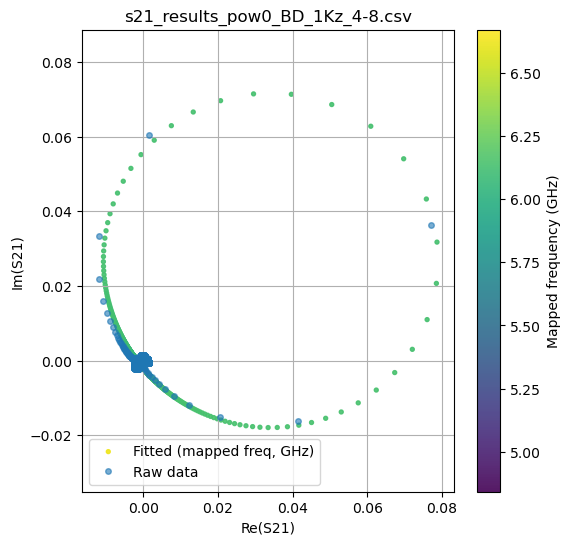

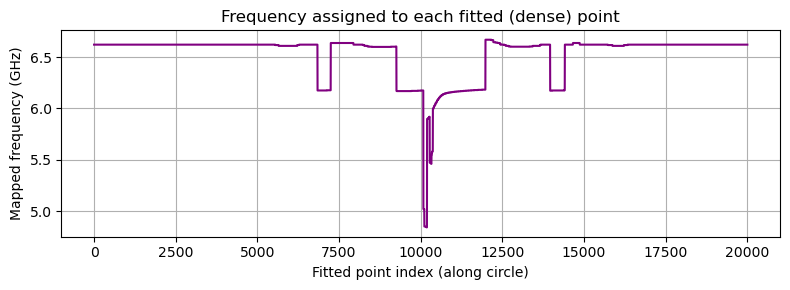

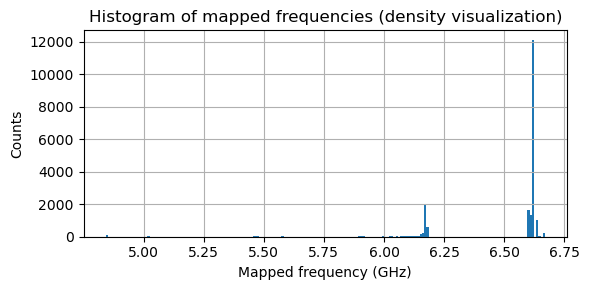


Fit parameters:
  f0 = 6.132695817e+09 Hz, k = 2.867694917e+06, amp = 8.829488e-02, phi = 29.160, tau = 1.718e-09 s

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 6.621311 GHz
  idx  2500 -> 6.621311 GHz
  idx  5000 -> 6.621311 GHz
  idx 10000 -> 6.173087 GHz
  idx 15000 -> 6.621311 GHz
  idx 19999 -> 6.621311 GHz


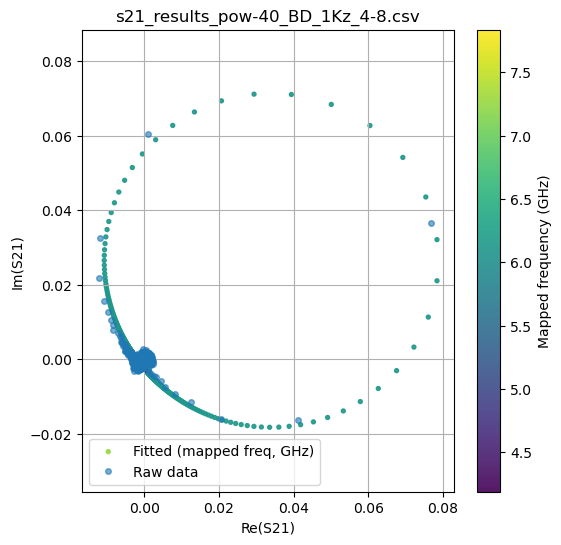

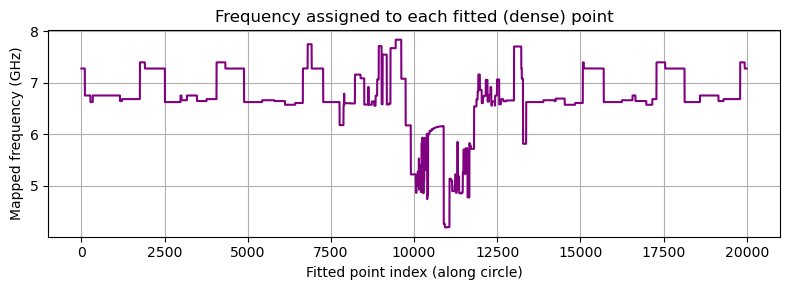

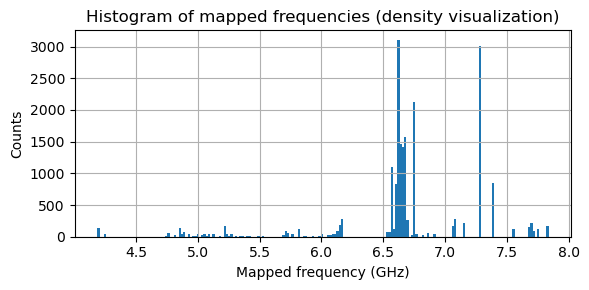


Fit parameters:
  f0 = 6.132706783e+09 Hz, k = 2.893295086e+06, amp = 8.794248e-02, phi = 43.099, tau = 2.080e-09 s

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 7.275638 GHz
  idx  2500 -> 7.275638 GHz
  idx  5000 -> 6.623312 GHz
  idx 10000 -> 5.218609 GHz
  idx 15000 -> 6.605303 GHz
  idx 19999 -> 7.275638 GHz


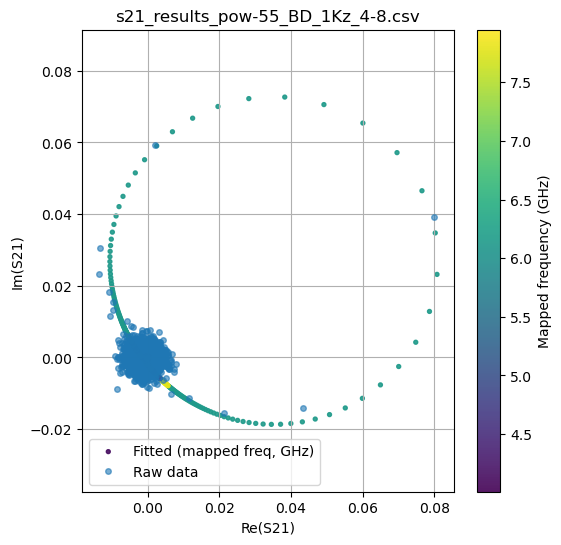

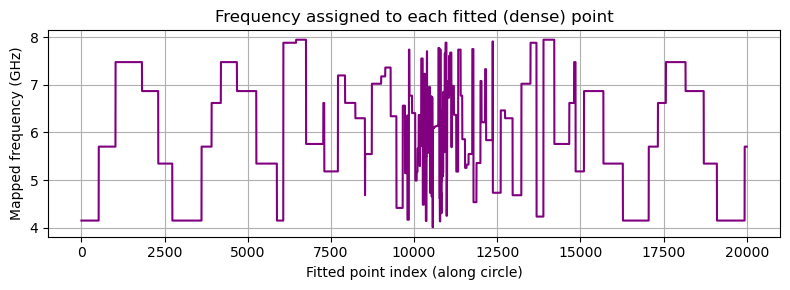

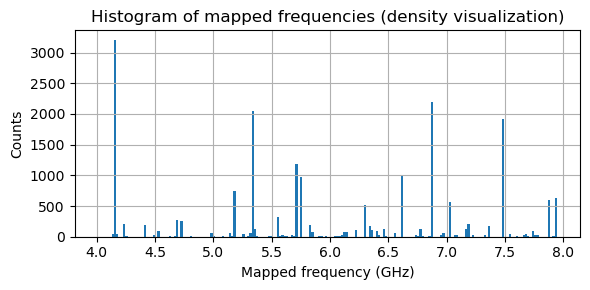


Fit parameters:
  f0 = 6.132752216e+09 Hz, k = 2.859953777e+06, amp = 9.008306e-02, phi = 27.562, tau = 1.677e-09 s

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 4.150075 GHz
  idx  2500 -> 5.346673 GHz
  idx  5000 -> 6.869435 GHz
  idx 10000 -> 6.407204 GHz
  idx 15000 -> 5.182591 GHz
  idx 19999 -> 5.702851 GHz


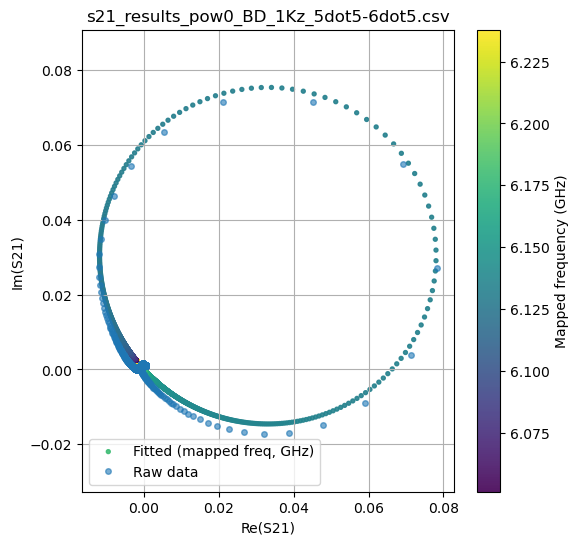

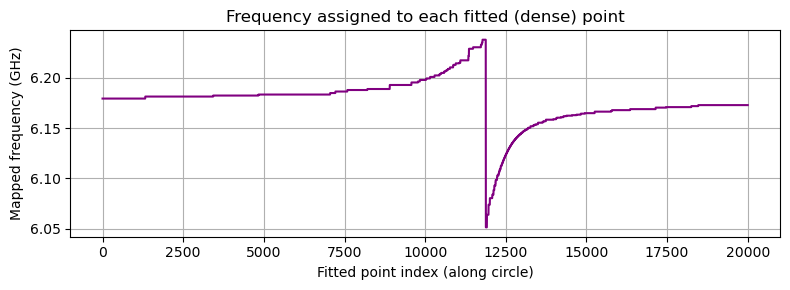

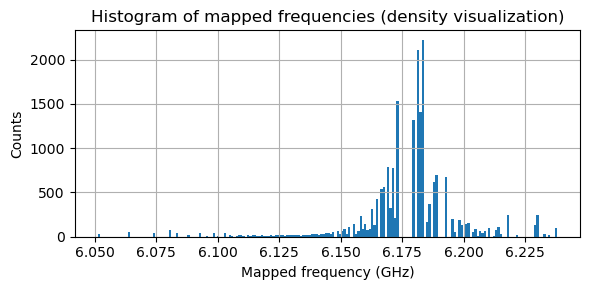


Fit parameters:
  f0 = 6.132670345e+09 Hz, k = 2.760321807e+06, amp = 8.987930e-02, phi = 0.743

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 6.179340 GHz
  idx  2500 -> 6.181341 GHz
  idx  5000 -> 6.183342 GHz
  idx 10000 -> 6.197849 GHz
  idx 15000 -> 6.164832 GHz
  idx 19999 -> 6.172836 GHz


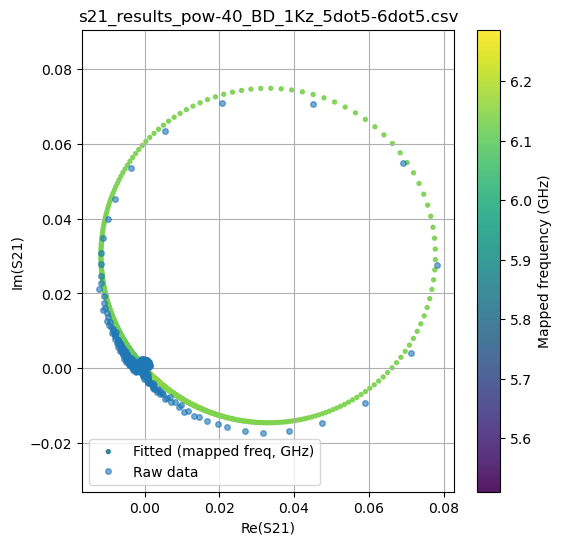

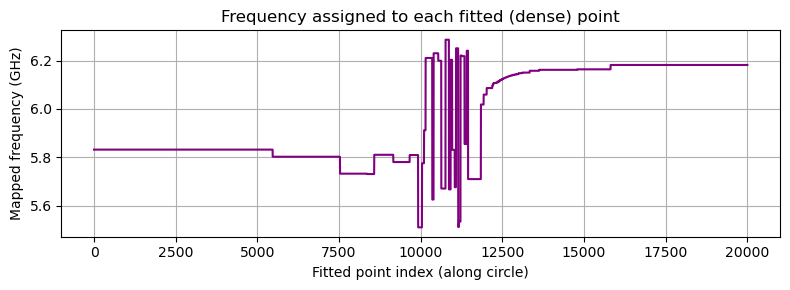

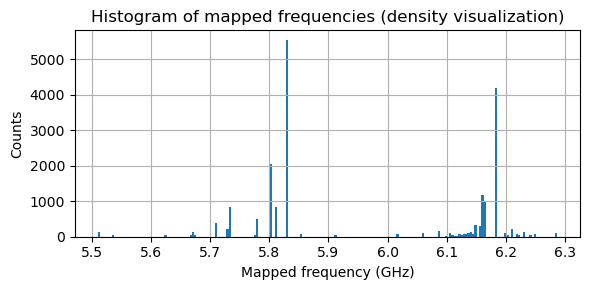


Fit parameters:
  f0 = 6.132677914e+09 Hz, k = 2.759153115e+06, amp = 8.949302e-02, phi = 0.739

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 5.831666 GHz
  idx  2500 -> 5.831666 GHz
  idx  5000 -> 5.831666 GHz
  idx 10000 -> 5.510005 GHz
  idx 15000 -> 6.163832 GHz
  idx 19999 -> 6.181841 GHz


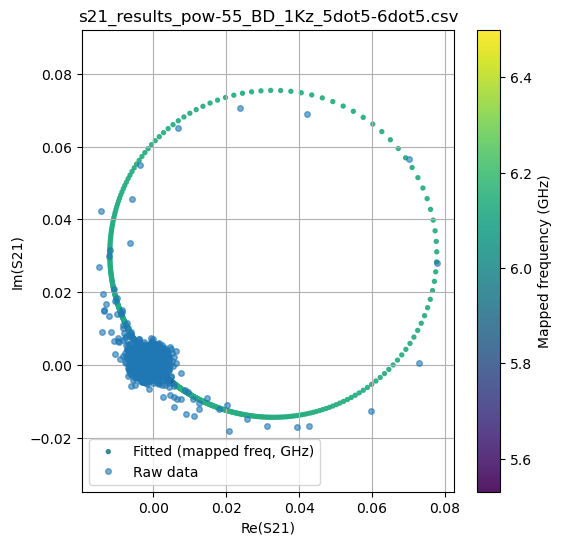

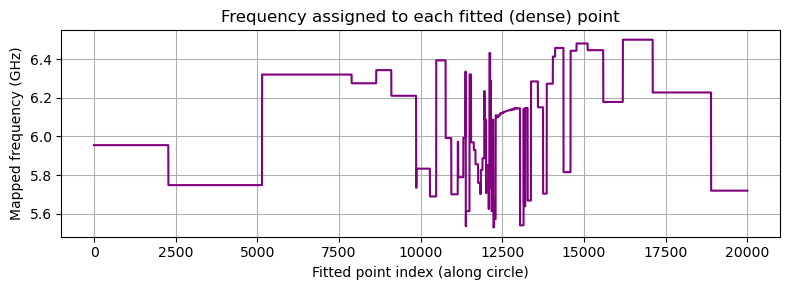

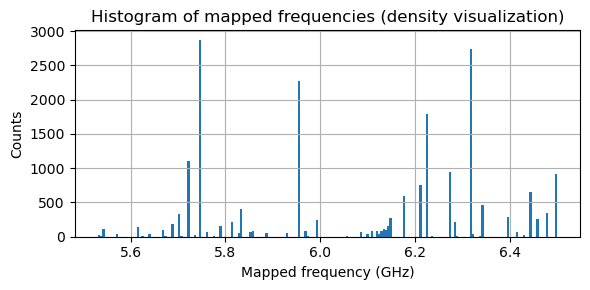


Fit parameters:
  f0 = 6.132648198e+09 Hz, k = 2.767466253e+06, amp = 8.976045e-02, phi = 0.748

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 5.955228 GHz
  idx  2500 -> 5.748624 GHz
  idx  5000 -> 5.748624 GHz
  idx 10000 -> 5.833667 GHz
  idx 15000 -> 6.480490 GHz
  idx 19999 -> 5.720110 GHz


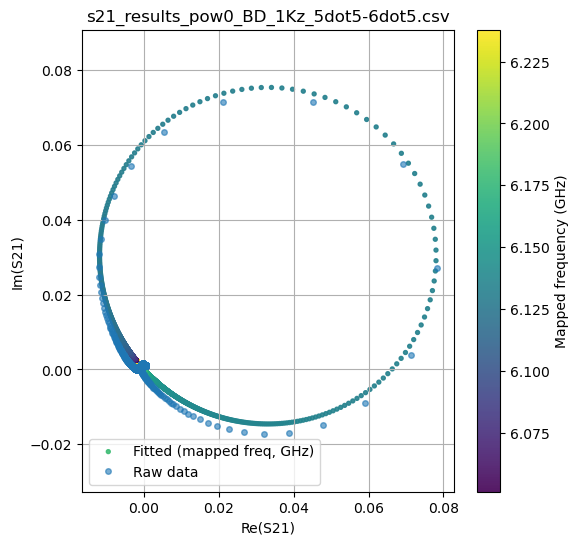

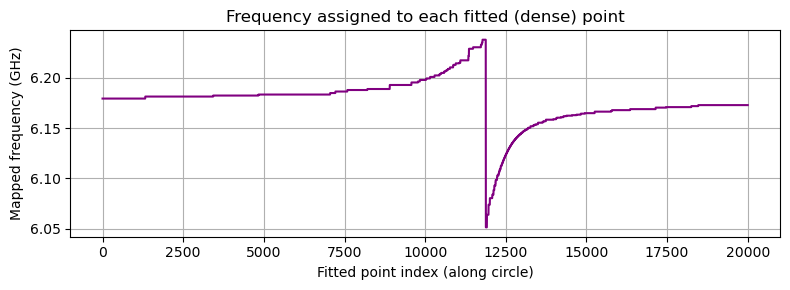

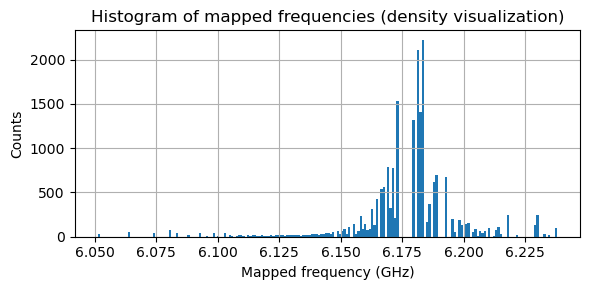


Fit parameters:
  f0 = 6.132670345e+09 Hz, k = 2.760321807e+06, amp = 8.987930e-02, phi = 0.743

Sample mapped frequencies (GHz) at selected fitted indices:
  idx     0 -> 6.179340 GHz
  idx  2500 -> 6.181341 GHz
  idx  5000 -> 6.183342 GHz
  idx 10000 -> 6.197849 GHz
  idx 15000 -> 6.164832 GHz
  idx 19999 -> 6.172836 GHz


(array([6.13267034e+09, 2.76032181e+06, 8.98793016e-02, 7.42790375e-01]),
 array([5.50000000e+09, 5.50005000e+09, 5.50010001e+09, ...,
        6.49989999e+09, 6.49995000e+09, 6.50000000e+09]),
 array([-0.0001323 +0.00014471j, -0.00013231+0.00014472j,
        -0.00013232+0.00014473j, ...,  0.0002294 -0.00024795j,
         0.00022937-0.00024792j,  0.00022933-0.00024788j]),
 array([6.17933967e+09, 6.17933967e+09, 6.17933967e+09, ...,
        6.17283642e+09, 6.17283642e+09, 6.17283642e+09]))

In [5]:
# =========================================================
# --- Frequency density visualization ---
# =========================================================
plt.figure(figsize=(8,5))
plt.hist(f_mapped, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count (density along circle)")
plt.title("Frequency density of fitted-circle points (denser near dip)")
plt.grid(True)
plt.show()


NameError: name 'f_mapped' is not defined

<Figure size 800x500 with 0 Axes>